In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import itertools
import json
import os

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn
import sklearn.cluster
import torch
import tqdm
import umap
# import umap.parametric_umap

import celltrip
  

mpl.rcParams['pdf.fonttype'] = 42


2025-12-29 16:06:02.230710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [3]:
# Read data
adata, = celltrip.utility.processing.read_adatas('s3://nkalafut-celltrip/ExpVal/expression.h5ad', backed=True)
sample_mask = np.random.rand(adata.shape[0]) < .1  # 76,855 total, REMOVE
adata = adata[sample_mask]

# Correct variables
adata.obs['age_orig'] = adata.obs['age']
adata.obs['age'] = adata.obs['age'].apply(lambda x: {  # Translate ages
    i+1: v for i, v in enumerate((85, 95, 100, 105, 110, 125, 145, 155))}[x])
adata.obs['subtype_orig'] = adata.obs['subtype']
adata.obs['subtype'] = adata.obs['subtype'].map(lambda s: ' '.join(s.split(' ')[:2]), na_action='ignore')  # Shorten subtypes

# Normalize data for visualization
sim_data = adata.X[:]
sim_data_norm = 10_000 * sim_data / sim_data.sum(axis=1)

# Load manager
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/ExpVal-251120', 800
manager = celltrip.manager.BasicManager(
    policy_fname=f'{prefix}-{training_step:04}.weights',
    preprocessing_fname=f'{prefix}.pre',
    mask_fname=f'{prefix}.mask',
    device='cuda')
manager.set_modalities([adata], suppress_warning=True)


/tmp/ipykernel_5906/2666922103.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['age_orig'] = adata.obs['age']


# Simulate

In [4]:
# Simulate to steady state
manager.reset_env()
manager.simulate(skip_time=512., impute=False)
manager.save_state('steady')
steady_gex, = manager.get_state()

100%|██████████| 5120/5120 [01:50<00:00, 46.40it/s]


## Visualize

In [5]:
# Reduce observed
# red = umap.parametric_umap.UMAP(
red = umap.UMAP(
    # low_memory=True,
    # random_state=42,
)
sim_data_embed = red.fit_transform(sim_data_norm)
sim_data_embed = pd.DataFrame(sim_data_embed, index=adata.obs_names, columns=[f'UMAP-{i+1}' for i in range(sim_data_embed.shape[1])])
sim_data_embed['subtype'] = adata.obs['subtype']
sim_data_embed['sample'] = adata.obs['sample']
sim_data_embed['age'] = adata.obs['age']
sim_data_embed['source'] = 'Observed'

# Reduce CellTRIP
steady_gex_embed = red.transform(steady_gex)  # np.concat([sim_data, steady_gex], axis=0)
steady_gex_embed = pd.DataFrame(steady_gex_embed, index=adata.obs_names, columns=[f'UMAP-{i+1}' for i in range(steady_gex_embed.shape[1])])
steady_gex_embed['subtype'] = adata.obs['subtype']
steady_gex_embed['sample'] = adata.obs['sample']
steady_gex_embed['age'] = adata.obs['age']
steady_gex_embed['source'] = 'CellTRIP'

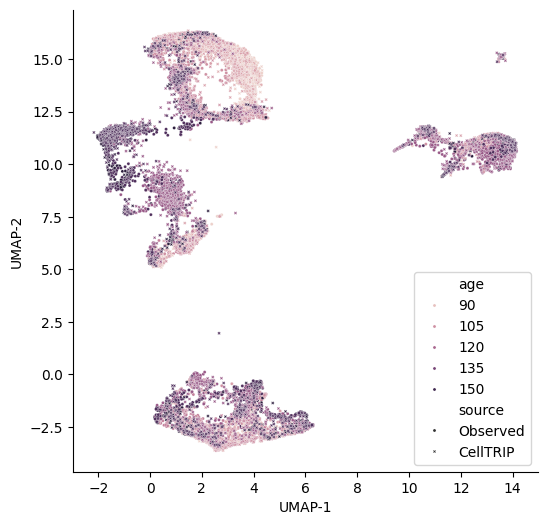

In [6]:
# Concatenate
concat_embed = pd.concat([sim_data_embed, steady_gex_embed], axis=0)

# Plot observed vs. CellTRIP
fig, ax = plt.subplots(figsize=(6, 6))
var = 'age'  # 'subtype'

sns.scatterplot(concat_embed, x='UMAP-1', y='UMAP-2', hue=var, style='source', s=5, legend=True, ax=ax)
sns.despine(ax=ax)
# Annotate
# var_means = concat_embed.groupby(var, observed=True)[['UMAP-0', 'UMAP-1']].median()
# for var, r in var_means.iterrows():
#     ax.text(*r.to_numpy(), var, ha='center', va='center', fontsize='xx-small', transform=ax.transData)

# Save
fig.savefig('../plots/expval/age_umap.pdf')

# Knockdown

In [7]:
# Parameters
samples_to_perturb = adata.obs['sample'].unique()
genes_to_perturb = (
    'RAPGEF4', 'CHD8',  # Experimental genes for neuronal maturation
    'MEIS2', 'NFIA', 'NFIB',  # Known TFs for neuronal maturation
)

In [8]:
# Initialize
pert_results = []
for sample in samples_to_perturb:
    # Filter adata
    adata_sample = adata[adata.obs['sample']==sample]
    sample_age = adata_sample.obs['age'].iloc[0]
    manager.set_modalities([adata_sample], suppress_warning=True)
    identifier = f'{sample_age} ({sample})'

    # Simulate to steady state
    print(f'Simulating sample {sample} of age {sample_age}...')
    manager.reset_env()
    manager.simulate(skip_time=512., impute=False)
    manager.save_state('steady')
    steady_gex, = manager.get_state()

    # Get control
    time, states = manager.simulate_perturbation(skip_time=512., time=128.)
    control_gex, = manager.get_state()

    # Revert to previous state
    manager.load_state('steady')
    manager.clear_perturbations()

    # Perturb chosen genes
    for gene in genes_to_perturb:
        # Simulate perturbation
        print(f'Perturbing gene {gene}...')
        manager.add_perturbation([gene], modality=0, feature_targets=0)
        time, states = manager.simulate_perturbation(skip_time=512., time=128., progress_bar=False, impute=False)
        knocked_gex, = manager.get_state()

        # Get statistics
        diff = pd.DataFrame(index=adata_sample.obs_names)
        diff['subtype'] = adata_sample.obs['subtype']
        diff['Steady GES'] = np.sqrt(np.square(knocked_gex - steady_gex).sum(axis=1))
        diff['Control GES'] = np.sqrt(np.square(knocked_gex - control_gex).sum(axis=1))
        diff_means = diff.groupby('subtype', observed=True).mean()
        for subtype in ['All'] + adata_sample.obs['subtype'].unique().tolist():
            if subtype == 'All': diff_results = diff.drop(columns=['subtype']).mean(axis=0).to_dict()
            else: diff_results = diff_means.loc[subtype].to_dict()
            pert_results.append({
                'Identifier': identifier,
                'Sample': sample,
                'Age': sample_age,
                'Gene': gene,
                'Subtype': subtype,
                **diff_results})

        # Revert to previous state
        manager.load_state('steady')
        manager.clear_perturbations()

# Convert to DataFrame
sort_order = ['Age', 'Sample', 'Gene', 'Subtype']
pert_results = pd.DataFrame(pert_results).sort_values(sort_order)

Simulating sample 1 of age 85...


100%|██████████| 1280/1280 [00:06<00:00, 187.14it/s]


Perturbing gene RAPGEF4...
Perturbing gene CHD8...
Perturbing gene MEIS2...
Perturbing gene NFIA...
Perturbing gene NFIB...
Simulating sample 2 of age 95...


100%|██████████| 1280/1280 [00:03<00:00, 359.26it/s]


Perturbing gene RAPGEF4...
Perturbing gene CHD8...
Perturbing gene MEIS2...
Perturbing gene NFIA...
Perturbing gene NFIB...
Simulating sample 3 of age 100...


100%|██████████| 1280/1280 [00:03<00:00, 366.14it/s]


Perturbing gene RAPGEF4...
Perturbing gene CHD8...
Perturbing gene MEIS2...
Perturbing gene NFIA...
Perturbing gene NFIB...
Simulating sample 5 of age 110...


100%|██████████| 1280/1280 [00:07<00:00, 182.37it/s]


Perturbing gene RAPGEF4...
Perturbing gene CHD8...
Perturbing gene MEIS2...
Perturbing gene NFIA...
Perturbing gene NFIB...
Simulating sample 9 of age 155...


100%|██████████| 1280/1280 [00:03<00:00, 367.31it/s]


Perturbing gene RAPGEF4...
Perturbing gene CHD8...
Perturbing gene MEIS2...
Perturbing gene NFIA...
Perturbing gene NFIB...
Simulating sample 4 of age 105...


100%|██████████| 1280/1280 [00:03<00:00, 367.58it/s]


Perturbing gene RAPGEF4...
Perturbing gene CHD8...
Perturbing gene MEIS2...
Perturbing gene NFIA...
Perturbing gene NFIB...
Simulating sample 10 of age 155...


100%|██████████| 1280/1280 [00:03<00:00, 368.89it/s]


Perturbing gene RAPGEF4...
Perturbing gene CHD8...
Perturbing gene MEIS2...
Perturbing gene NFIA...
Perturbing gene NFIB...
Simulating sample 6 of age 125...


100%|██████████| 1280/1280 [00:06<00:00, 186.19it/s]


Perturbing gene RAPGEF4...
Perturbing gene CHD8...
Perturbing gene MEIS2...
Perturbing gene NFIA...
Perturbing gene NFIB...
Simulating sample 7 of age 125...


100%|██████████| 1280/1280 [00:03<00:00, 364.69it/s]


Perturbing gene RAPGEF4...
Perturbing gene CHD8...
Perturbing gene MEIS2...
Perturbing gene NFIA...
Perturbing gene NFIB...
Simulating sample 8 of age 145...


100%|██████████| 1280/1280 [00:03<00:00, 368.94it/s]


Perturbing gene RAPGEF4...
Perturbing gene CHD8...
Perturbing gene MEIS2...
Perturbing gene NFIA...
Perturbing gene NFIB...


## Visualize

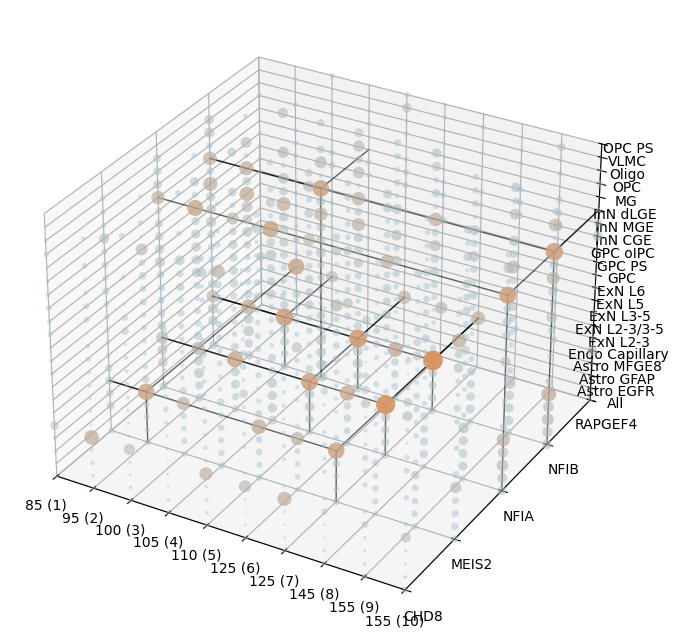

In [9]:
# Params
subtypes_to_use = [
    'all', 'Astro EGFR', 'Endo Capillary', 'ExN L2-3 IT CUX2 BRINP3',
    'ExN L3-5 IT RORB ILRAPL2', 'ExN L5 ET POU3F1 RGMA', 'ExN L6 B NR4A2 ARHGAP6',
    'InN CGE ADARB2 CCK', 'InN MGE SOX6 BMPER', 'InN dLGE MEIS2 KCNK13',
    'MG', 'OPC', 'OPC PS', 'Oligo', 'VLMC']

# Get labels and data
pert_filter = pert_results
# pert_filter = pert_filter.loc[pert_results['Subtype'].isin(subtypes_to_use)]
pert_filter = pert_filter.sort_values(sort_order)
xlabels, x = np.unique(pert_filter['Identifier'], return_inverse=True)
x, xlabels = pd.factorize(pert_filter['Identifier'])  # Factorize keeps order, as opposed to `np.unique(..., return_inverse=True)`
xticks = list(range(len(xlabels)))
y, ylabels = pd.factorize(pert_filter['Gene'])
yticks = list(range(len(ylabels)))
z, zlabels = pd.factorize(pert_filter['Subtype'])
zticks = list(range(len(zlabels)))
values = pert_filter['Control GES'].to_numpy()
values = values/values.max()

# Create figure
fig = plt.figure(figsize=(8, 16))
ax = fig.add_subplot(projection='3d')

# Plot heatmap
ax.scatter(
    x, y, z, c=[(1-v)*np.array((160/256, 200/256, 220/256, .4))+v*np.array((220/256, 150/256, 100/256, 1.)) for v in values], lw=0,
    depthshade=False,  # Incompatible with alpha
    s=200*values)

# Orienting lines
# for _x, _y in itertools.product(xticks, yticks):
#     ax.plot([_x, _x], [_y, _y], [0, len(zticks)-1], color='k', alpha=.3, lw=1)
# for _x, _z in itertools.product(xticks, zticks):
#     ax.plot([_x, _x], [0, len(yticks)-1], [_z, _z], color='k', alpha=.3, lw=1)
# for _y, _z in itertools.product(yticks, zticks):
#     ax.plot([0, len(xticks)-1], [_y, _y], [_z, _z], color='k', alpha=.3, lw=1)
for i in np.argwhere(values > .7).flatten():
    ax.plot([x[i], 0], [y[i], y[i]], [z[i], z[i]], color='k', alpha=.6, lw=1, zorder=0)
    ax.plot([x[i], x[i]], [y[i], len(yticks)-1], [z[i], z[i]], color='k', alpha=.6, lw=1, zorder=0)
    ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], 0], color='k', alpha=.6, lw=1, zorder=0)

# Labels
ax.set( 
    xticks=xticks, xticklabels=xlabels,
    yticks=yticks, yticklabels=ylabels,
    zticks=zticks, zticklabels=zlabels)
ax.set(xlim=[0, len(xticks)-1], ylim=[0, len(yticks)-1], zlim=[0, len(zticks)-1])

# Save
# ax.axis('off')
fig.savefig('../plots/expval/heatmap.pdf')
fig.show()

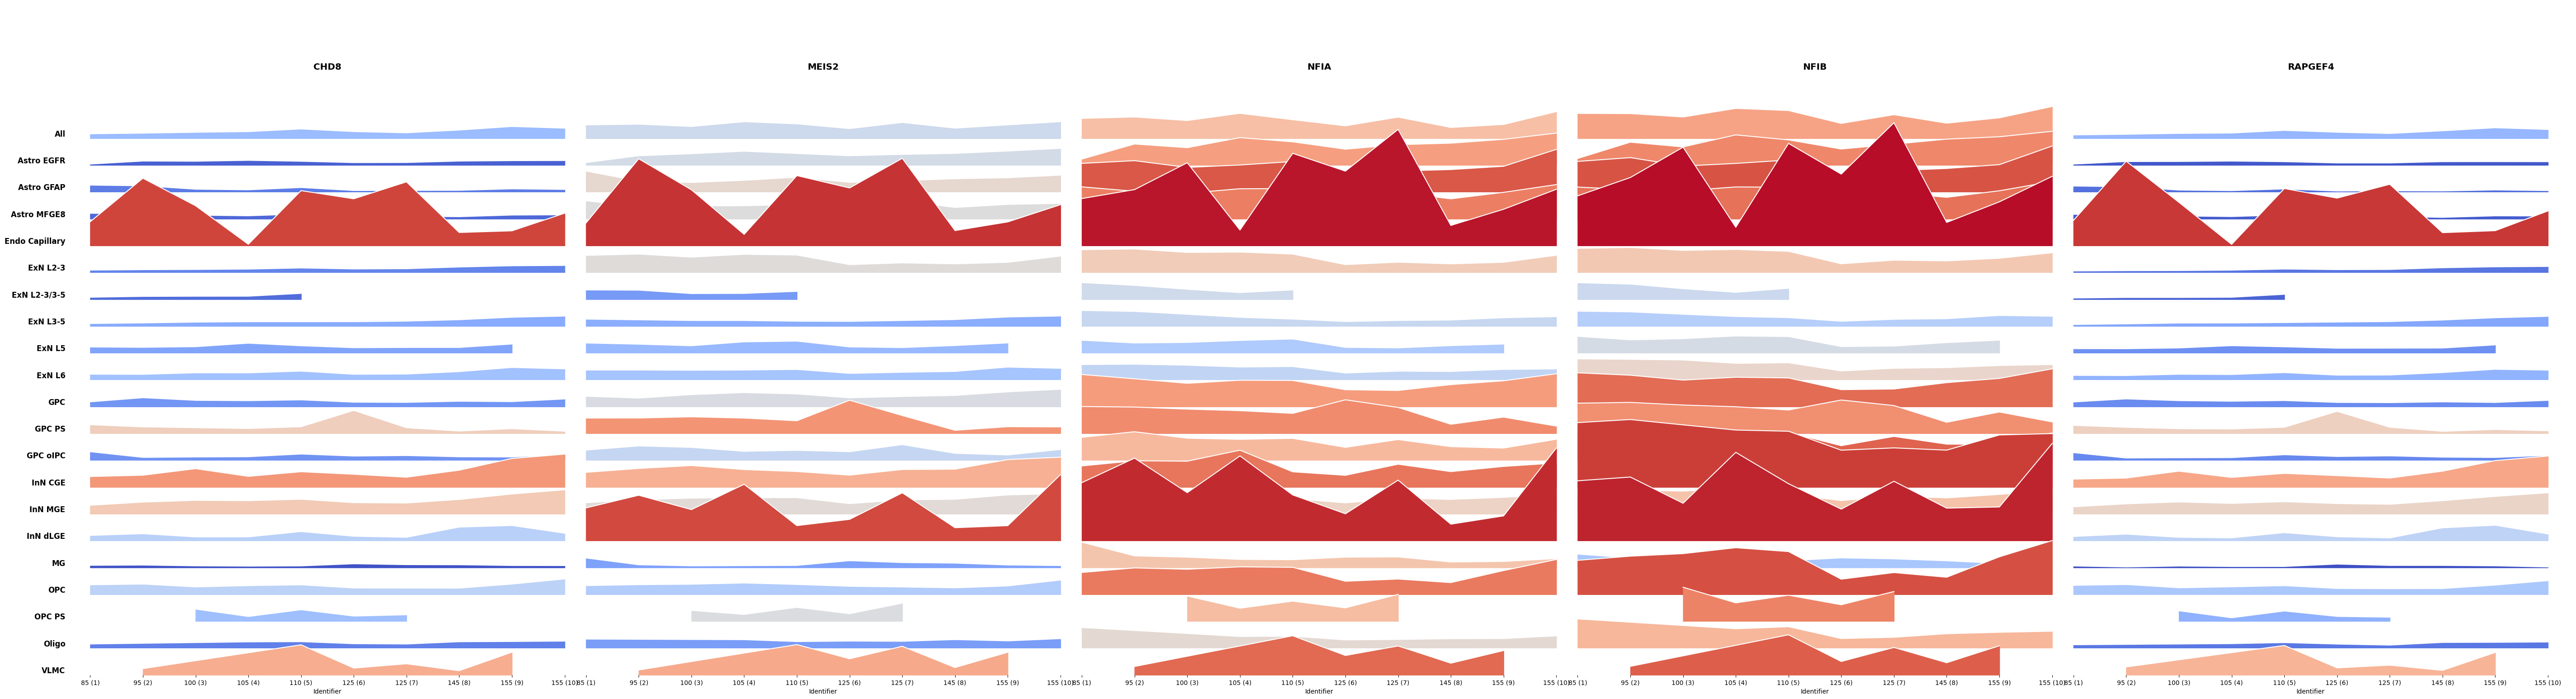

In [ ]:
# Modified from https://python-graph-gallery.com/ridgeline-graph-seaborn/
# Create grid
pert_filter = pert_results
# pert_filter = pert_filter.loc[pert_results['Subtype'].isin(subtypes_to_use)]  # Filter to select subtypes
# pert_filter = pert_filter.loc[pert_filter['Gene']=='RAPGEF4']  # Filter to one gene
pert_filter = pert_filter.copy().sort_values(['Subtype', 'Age', 'Sample'])  # Not the best sort
subtype_gene_max = pert_filter.groupby(['Subtype', 'Gene'])['Control GES'].max()
subtype_mean = pert_filter.groupby('Subtype')['Control GES'].mean()
pert_filter['Subtype Gene Max Control GES'] = pert_filter[['Subtype', 'Gene']].apply(lambda x: subtype_gene_max[tuple(x)], axis=1).to_numpy()
g = sns.FacetGrid(
    pert_filter, row='Subtype', col='Gene', hue='Subtype Gene Max Control GES',
    palette='coolwarm', aspect=15, height=0.75)
# g.fig.patch.set_facecolor('None')
for ax in g.axes.flat: ax.patch.set_facecolor('None')

# Plot
g.map(sns.lineplot, 'Identifier', 'Control GES', errorbar=None, color='white')
def fillplot(*args, ax=None, alpha=1., **kwargs):
    # Adapted from https://stackoverflow.com/a/77068597
    if ax is None: ax = plt.gca()
    for line in ax.lines:
        x, y = line.get_xydata().T
        ax.fill_between(x, 0, y, alpha=alpha, **kwargs)
g.map(fillplot, 'Identifier', 'Control GES')

# Labels and titles
for (subtype, gene), ax in g.axes_dict.items():
    is_first_gene = gene == pert_filter['Gene'].iloc[0]
    is_first_subtype = subtype == pert_filter['Subtype'].iloc[0]
    if is_first_gene:
        ax.text(
            -0.002, .002, subtype,
            fontweight='bold', fontsize='large',
            ha='right', va='bottom',
            color='black',
            transform=ax.transAxes)
    if is_first_subtype:
        ax.text(
            .5, .5, gene,
            fontweight='bold', fontsize='x-large',
            ha='center', va='bottom',
            color='black',
            transform=ax.transAxes)
    
# Remove extraneous formatting
g.set_titles('')
g.set(yticks=[], ylabel=None)
g.despine(bottom=True, left=True)
for ax in g.axes[:-1].flat: ax.tick_params(length=0)

# Adjust
g.set(ylim=(0, 1000))
g.fig.subplots_adjust(hspace=-.8)
g.fig.subplots_adjust(wspace=-.05)

# Save
g.fig.savefig('../plots/expval/effect_sizes.pdf')
g.fig.show()

In [ ]:
# Parameters
traj_pairs = [
    (3, 'RAPGEF4'),  #
    (3, 'MEIS2'),
    (3, 'NFIA'),
    (3, 'NFIB'),
    (3, 'CHD8'),
    (3, 'MEIS2'),
    (7, 'RAPGEF4'),
    (7, 'MEIS2'),  #
    (7, 'NFIA'),
    (7, 'NFIB'),
    (7, 'CHD8'),
    (7, 'MEIS2'),
    (10, 'RAPGEF4'),
    (10, 'MEIS2'),
    (10, 'NFIA'),  #
    (10, 'NFIB'),
    (10, 'CHD8'),
    (10, 'MEIS2'),
]

# Perturb
trajectories = {}
for traj_pair in traj_pairs:
    # Split
    sample, gene = traj_pair

    # Filter adata
    print(f'Testing {gene} on sample {sample}...')
    adata_sample = adata[adata.obs['sample']==sample]
    manager.set_modalities([adata_sample], suppress_warning=True)

    # Simulate to steady state
    manager.reset_env()
    manager.simulate(skip_time=512., impute=False)
    manager.save_state('steady')

    # Perturb chosen gene
    manager.add_perturbation([gene], modality=0, feature_targets=0)
    time, states = manager.simulate_perturbation(skip_time=2., time=10., progress_bar=True)
    trajectories[traj_pair] = (time, states[0])

Testing RAPGEF4 on sample 3...


  7%|▋         | 370/5120 [00:01<00:12, 368.68it/s]

100%|██████████| 5120/5120 [00:14<00:00, 363.02it/s]
101it [00:00, 332.56it/s]                        


Testing MEIS2 on sample 3...


100%|██████████| 5120/5120 [00:14<00:00, 359.08it/s]
101it [00:00, 305.84it/s]                        


Testing NFIA on sample 3...


100%|██████████| 5120/5120 [00:14<00:00, 363.48it/s]
101it [00:00, 278.10it/s]                        


Testing CHD8 on sample 3...


100%|██████████| 5120/5120 [00:14<00:00, 362.41it/s]
101it [00:00, 266.24it/s]                        


Testing MEIS2 on sample 3...


100%|██████████| 5120/5120 [00:14<00:00, 359.19it/s]
101it [00:00, 248.11it/s]                        


Testing RAPGEF4 on sample 7...


100%|██████████| 5120/5120 [00:14<00:00, 360.11it/s]
101it [00:00, 233.49it/s]                        


Testing MEIS2 on sample 7...


100%|██████████| 5120/5120 [00:14<00:00, 360.46it/s]
101it [00:00, 217.48it/s]                        


Testing NFIA on sample 7...


100%|██████████| 5120/5120 [00:14<00:00, 356.03it/s]
101it [00:00, 207.62it/s]                        


Testing CHD8 on sample 7...


100%|██████████| 5120/5120 [00:14<00:00, 362.45it/s]
101it [00:00, 192.71it/s]                         


Testing MEIS2 on sample 7...


100%|██████████| 5120/5120 [00:14<00:00, 362.35it/s]
101it [00:00, 181.44it/s]                        


Testing RAPGEF4 on sample 10...


100%|██████████| 5120/5120 [00:14<00:00, 364.46it/s]
101it [00:00, 176.39it/s]                        


Testing MEIS2 on sample 10...


100%|██████████| 5120/5120 [00:14<00:00, 362.23it/s]
101it [00:00, 174.47it/s]                        


Testing NFIA on sample 10...


100%|██████████| 5120/5120 [00:14<00:00, 365.33it/s]
101it [00:00, 167.69it/s]                        


Testing CHD8 on sample 10...


100%|██████████| 5120/5120 [00:13<00:00, 367.15it/s]
101it [00:00, 161.89it/s]                        


Testing MEIS2 on sample 10...


100%|██████████| 5120/5120 [00:13<00:00, 367.95it/s]
101it [00:00, 155.82it/s]                        


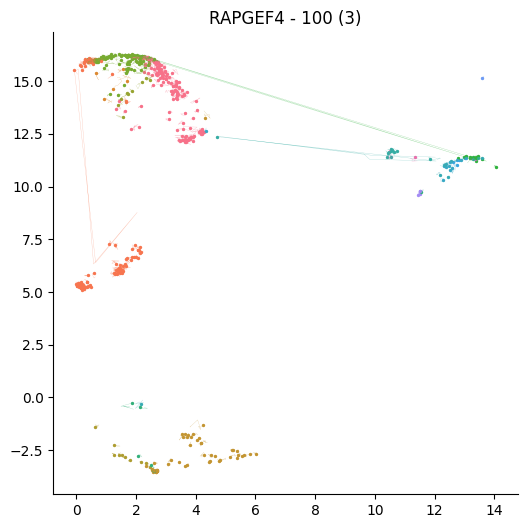

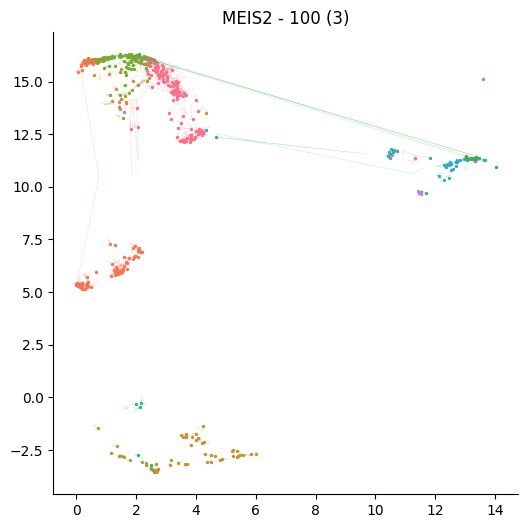

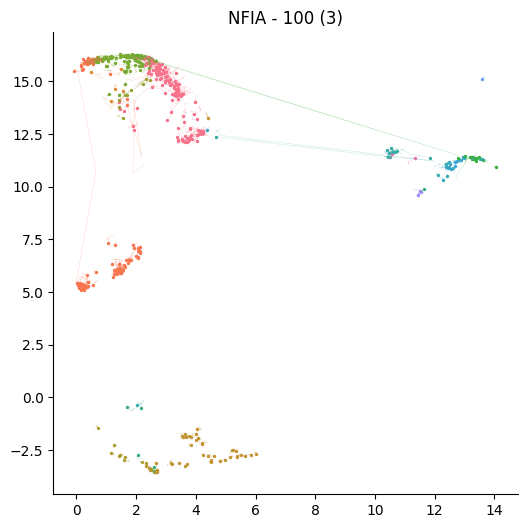

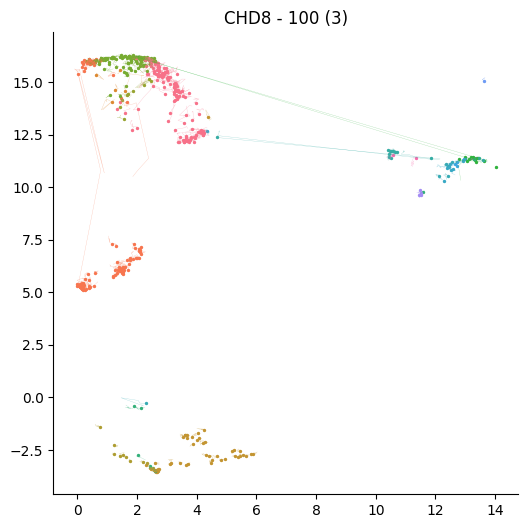

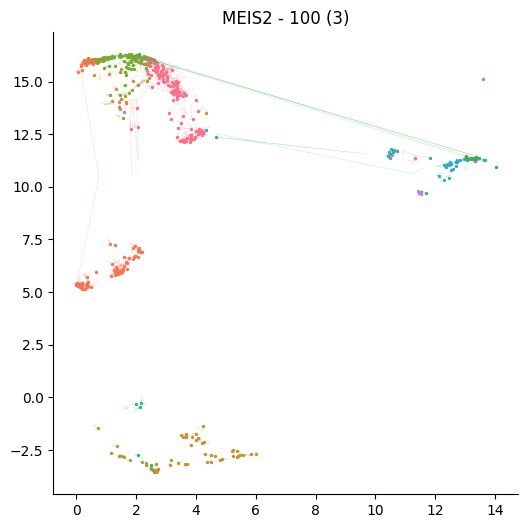

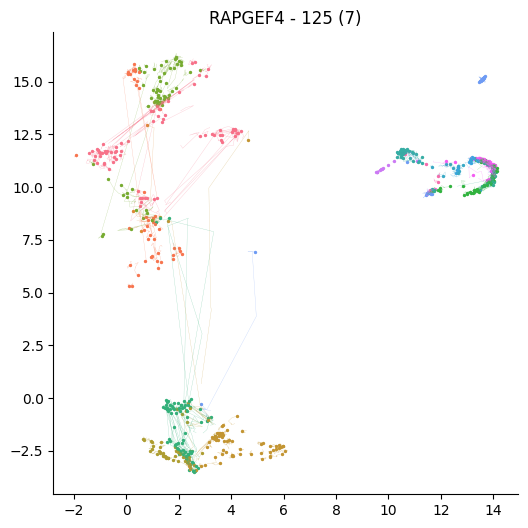

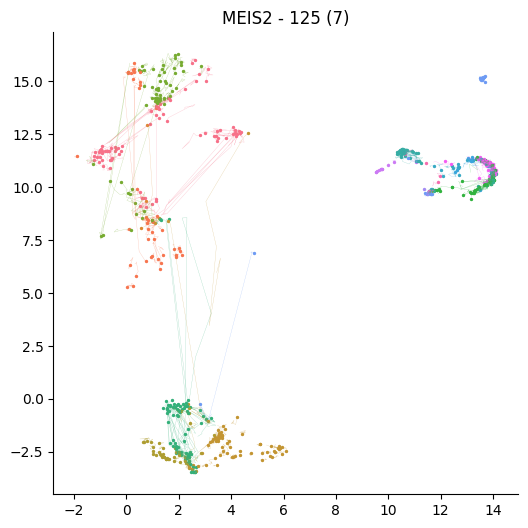

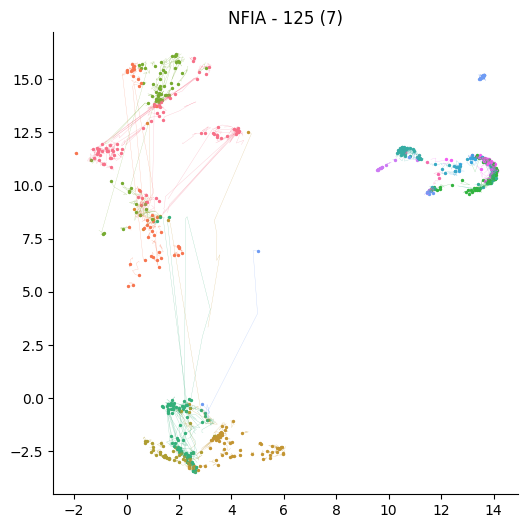

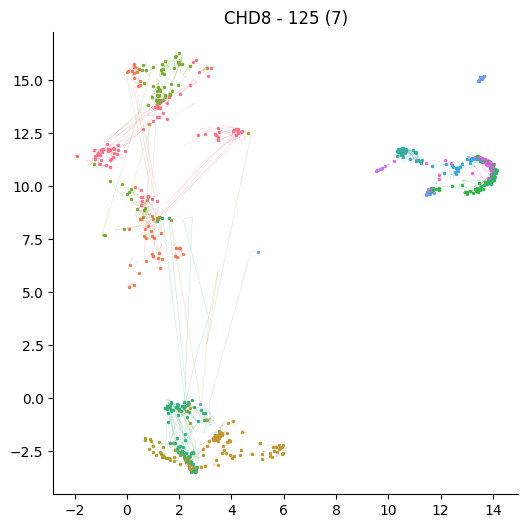

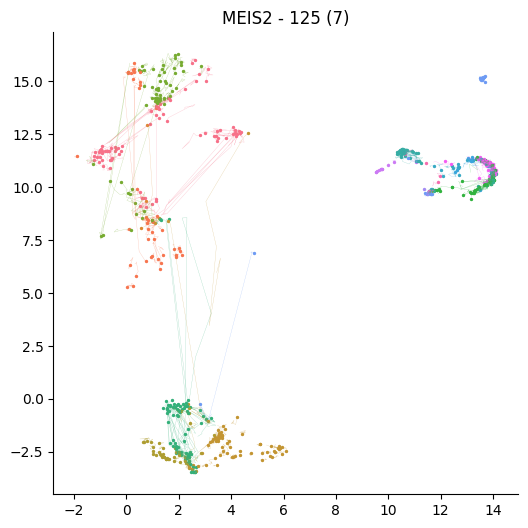

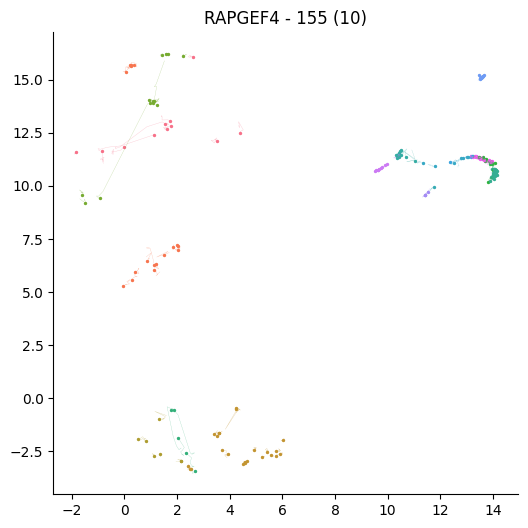

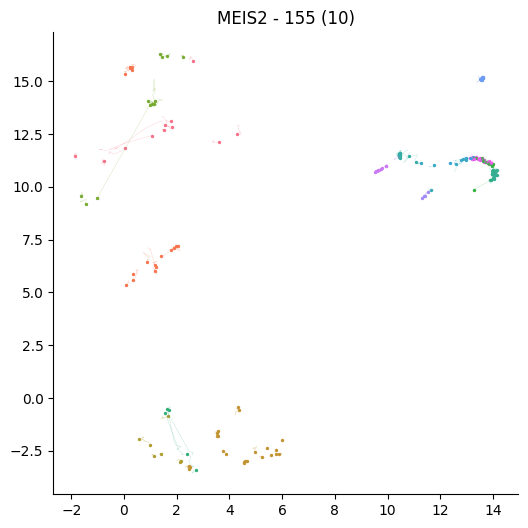

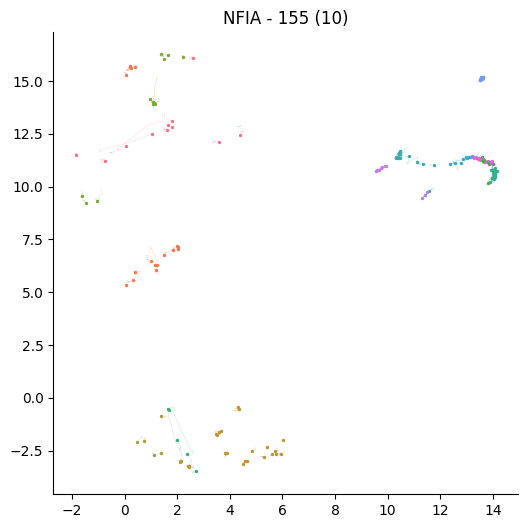

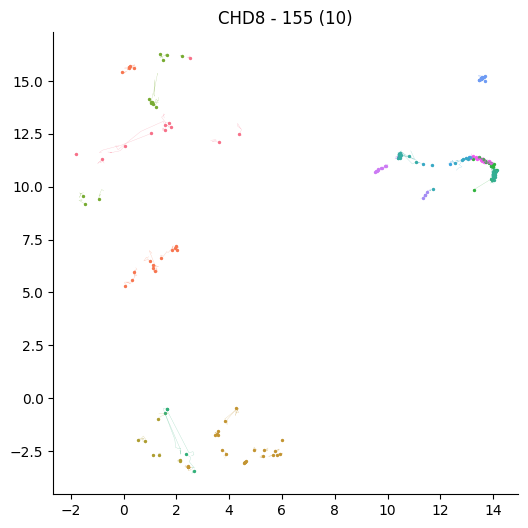

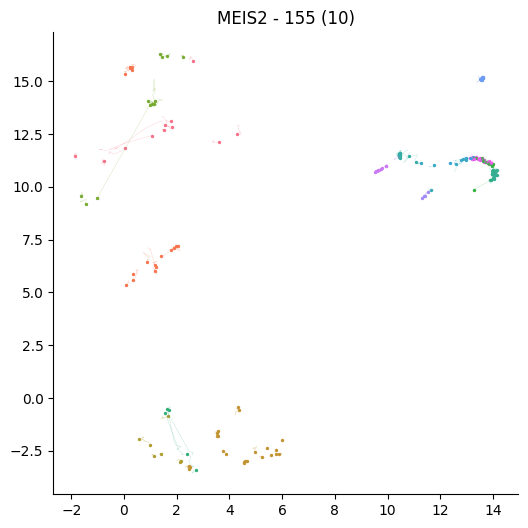

In [12]:
# Lines
for traj_pair in traj_pairs:
    # Split
    sample, gene = traj_pair
    sample_obs = adata[adata.obs['sample']==sample].obs
    sample_age = sample_obs['age'].iloc[0]

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Get data
    time, gex = trajectories[traj_pair]
    gex_embed = red.transform(gex.reshape((-1, gex.shape[-1]))).reshape((*gex.shape[:-1], 2))

    # Plot
    subtypes = adata.obs['subtype'].unique()
    palette = sns.color_palette(palette='husl', n_colors=len(subtypes))
    for cell_i in range(gex_embed.shape[1]):
        subtype = sample_obs['subtype'].iloc[cell_i]
        ax.scatter(
            *gex_embed[0, cell_i],
            color=palette[(subtypes==subtype).argmax()],
            label=subtype, s=2)
        ax.plot(
            *gex_embed[:, cell_i].T,
            color=palette[(subtypes==subtype).argmax()],
            alpha=.5, lw=.2)
    ax.set_title(f'{gene} - {sample_age} ({sample})')
    sns.despine(ax=ax)

    # Save
    fig.savefig(f'../plots/expval/{sample}_{gene}.pdf')


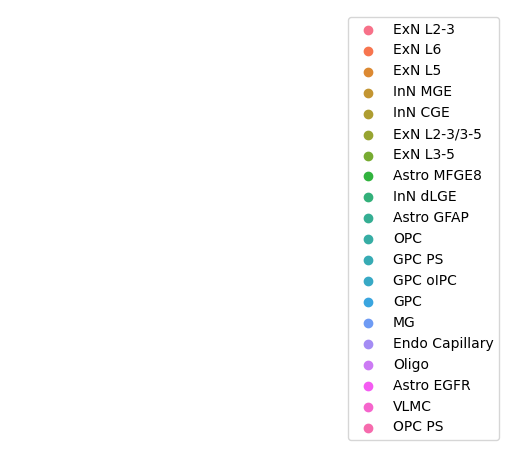

In [22]:
# Plot ct legend
fig, ax = plt.subplots(1, 1)
handles = [
    plt.scatter(None, None, color=palette[(subtypes==subtype).argmax()], label=subtype)
    for subtype in subtypes
]
ax.legend(handles=handles)
ax.axis('off');
fig.savefig('../plots/expval/ct_legend.pdf')